In [1]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from sklearn.ensemble import RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# reading data from sample dataset
# data = pd.read_csv('amazon_pc.csv')
data = pd.read_csv('/kaggle/input/amazon/appl_1_amazon_pc.csv')

In [4]:
# print 5 records from dataset
data.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1


In [5]:
# print various attributes available in the dataset
data.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'sentiment'],
      dtype='object')

In [6]:
# print properties of attributes in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        30846 non-null  object
 1   customer_id        30846 non-null  int64 
 2   review_id          30846 non-null  object
 3   product_id         30846 non-null  object
 4   product_parent     30846 non-null  int64 
 5   product_title      30846 non-null  object
 6   product_category   30846 non-null  object
 7   star_rating        30846 non-null  int64 
 8   helpful_votes      30846 non-null  int64 
 9   total_votes        30846 non-null  int64 
 10  vine               30846 non-null  object
 11  verified_purchase  30846 non-null  object
 12  review_headline    30846 non-null  object
 13  review_body        30846 non-null  object
 14  review_date        30846 non-null  object
 15  sentiment          30846 non-null  int64 
dtypes: int64(6), object(10)
memory usage: 3.

In [7]:
# adding a sentiment column to classify reviews as Positive or Negative
# Positive = 1
# Negative = 0

data['sentiment'] = np.where(data['star_rating'] == 5.0, 1,
                           np.where(data['star_rating'] == 4.0, 1, 0))

In [8]:
# get unique values of product title column
data["product_title"].unique()

array(['Fire HD 7, 7" HD Display, Wi-Fi, 8 GB'], dtype=object)

In [9]:
# choose a particular product for analysis
prod_hosa = data.loc[data["product_title"]=='Fire HD 7, 7" HD Display, Wi-Fi, 8 GB']
prod_hosa

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30841,US,44834233,R366C7ARIWLN7R,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3720,3875,N,Y,A great upgrade for me from an older Kindle Fire!,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,2014-10-03,1
30842,US,13376158,R35PL0AOCUXLU9,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,2716,2849,N,Y,Great Value for $139,I'm writing this review with the benefit of be...,2014-10-03,1
30843,US,40485963,R18ZJVY86AUFII,B00KC6XV58,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1525,1629,N,Y,Even grandma has it figured out!,"I purchased this Kindle for my grandma, becaus...",2014-10-03,1
30844,US,33485035,R36QVLQXMCZRSJ,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,143,163,N,Y,The Honda Accord of Tablets,I bought my tablet Fire HD 7 at Best Buy on th...,2014-10-03,1


In [10]:
# #split data-set to train and test

X = prod_hosa['review_body']
Y = prod_hosa['sentiment']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [11]:
# function to remove html elements from the reviews
def removeHTML(raw_text):
    clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text() 
    return clean_HTML

In [12]:
# function to remove special characters and numbers from the reviews4961
def removeSpecialChar(raw_text):
    clean_SpecialChar = re.sub("[^a-zA-Z]", " ", raw_text)  
    return clean_SpecialChar

In [13]:
# function to convert all reviews into lower case
def toLowerCase(raw_text):
    clean_LowerCase = raw_text.lower().split()
    return( " ".join(clean_LowerCase))  

In [14]:
# function to remove stop words from the reviews
def removeStopWords(raw_text):
    stops = set(stopwords.words("english"))
    words = [w for w in raw_text if not w in stops]
    return( " ".join(words))

In [15]:
# X_training clean set
X_train_cleaned = []

for val in X_train:
    val = removeHTML(val)
    val = removeSpecialChar(val)
    val = toLowerCase(val)
    removeStopWords(val) 
    X_train_cleaned.append(val) 

/tmp/ipykernel_20/3357511827.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text()


In [16]:
# X_testing clean set
X_test_cleaned = []

for val in X_test:
    val = removeHTML(val)
    val = removeSpecialChar(val)
    val = toLowerCase(val)
    removeStopWords(val)
    X_test_cleaned.append(val) 

/tmp/ipykernel_20/3357511827.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text()


In [17]:
# Convert a collection of raw documents to a matrix of TF-IDF features. This is required so as to train the model using features instead of 
# raw strings.
tvec = TfidfVectorizer(use_idf=True,
strip_accents='ascii')

X_train_tvec = tvec.fit_transform(X_train_cleaned)

In [18]:
# Support Vector Classifier model
svr_lin = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
svr_lin.fit(X_train_tvec, Y_train)

LinearSVC(dual=False)

In [19]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
svr_lin_predictions = svr_lin.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,svr_lin_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("yellow", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.770000,0.630000,0.700000,1018.000000
1,0.930000,0.960000,0.950000,5152.000000
accuracy,0.910000,0.910000,0.910000,0.910000
macro avg,0.850000,0.800000,0.820000,6170.000000
weighted avg,0.900000,0.910000,0.900000,6170.000000


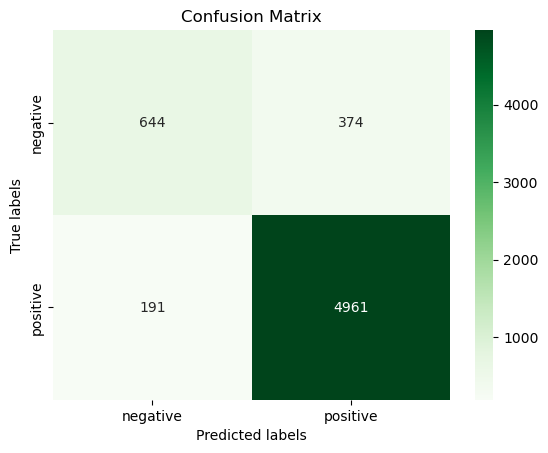

In [20]:
# confusion matrix
svr_lin_predictions=svr_lin.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,svr_lin_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [21]:
# testing the model with sample 'Negative' review
demo_review = np.array(['three days of use and it broke very disappointed in this product it worked perfectly for exactly three days and could not be resuscitated it was very inexpensive so i did not want to pay half again the price to ship it back for an exchange so the company would do nothing when they sent me an inquiry as to product satisfaction'])
demo_review_X_test = tvec.transform(demo_review)
print(svr_lin.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [22]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Excellent product. Works well and performs as expected.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(svr_lin.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [23]:
# Random Forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train_tvec, Y_train)

RandomForestClassifier()

In [24]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
ranfrst_predictions = random_forest.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,ranfrst_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("red", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.840000,0.280000,0.430000,1018.000000
1,0.880000,0.990000,0.930000,5152.000000
accuracy,0.870000,0.870000,0.870000,0.870000
macro avg,0.860000,0.640000,0.680000,6170.000000
weighted avg,0.870000,0.870000,0.850000,6170.000000


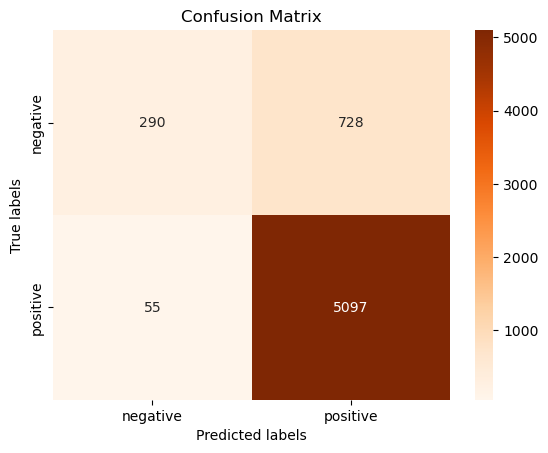

In [25]:
# confusion matrix
ranfrst_predictions=random_forest.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,ranfrst_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Oranges');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [26]:
# testing the model with sample 'Negative' review
demo_review = np.array(['Do not buy. Fake Product.'])
demo_review_X_test = tvec.transform(demo_review)
print(random_forest.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [27]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Original Product. Great Performance.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(random_forest.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [28]:
# K-Nearest Neighbor model
knn = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
knn.fit(X_train_tvec, Y_train)

KNeighborsClassifier()

In [29]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
knn_predictions = knn.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,knn_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("gray", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.740000,0.030000,0.060000,1018.000000
1,0.840000,1.000000,0.910000,5152.000000
accuracy,0.840000,0.840000,0.840000,0.840000
macro avg,0.790000,0.510000,0.490000,6170.000000
weighted avg,0.820000,0.840000,0.770000,6170.000000


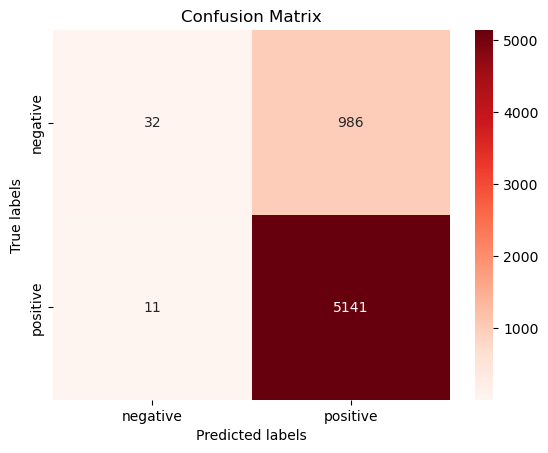

In [30]:
# confusion matrix
knn_predictions=knn.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,knn_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Reds');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [31]:
# testing the model with sample 'Negative' review
demo_review = np.array(['Bad product. Very much disappointed'])
demo_review_X_test = tvec.transform(demo_review)
print(knn.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [32]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Excellent product. Works well and performs as expected.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(knn.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [33]:
# Logistic regression model
lr = LogisticRegression()
lr.fit(X_train_tvec, Y_train)

LogisticRegression()

In [34]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
lr_predictions = lr.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,lr_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("purple", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.790000,0.590000,0.670000,1018.000000
1,0.920000,0.970000,0.950000,5152.000000
accuracy,0.910000,0.910000,0.910000,0.910000
macro avg,0.860000,0.780000,0.810000,6170.000000
weighted avg,0.900000,0.910000,0.900000,6170.000000


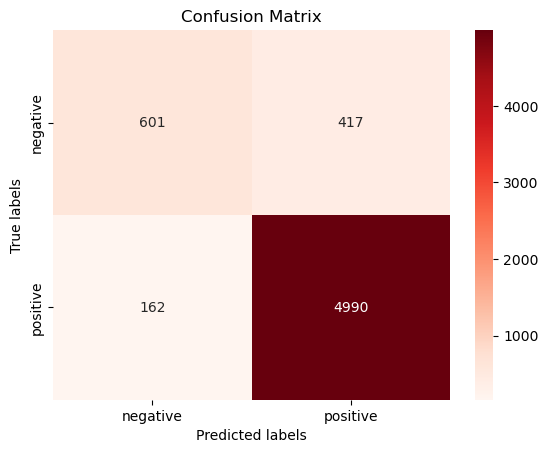

In [35]:
# confusion matrix
lr_predictions=lr.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,lr_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Reds');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [36]:
# testing the model with sample 'Negative' review
demo_review = np.array(['Poor quality. Faulty device.'])
demo_review_X_test = tvec.transform(demo_review)
print(lr.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [37]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Best product.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(lr.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [38]:
# Naive Bayes model
nbm = naive_bayes.MultinomialNB()
nbm.fit(X_train_tvec, Y_train)

MultinomialNB()

In [39]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 
nbm_predictions = nbm.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,nbm_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("blue", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.910000,0.150000,0.260000,1018.000000
1,0.860000,1.000000,0.920000,5152.000000
accuracy,0.860000,0.860000,0.860000,0.860000
macro avg,0.880000,0.570000,0.590000,6170.000000
weighted avg,0.860000,0.860000,0.810000,6170.000000


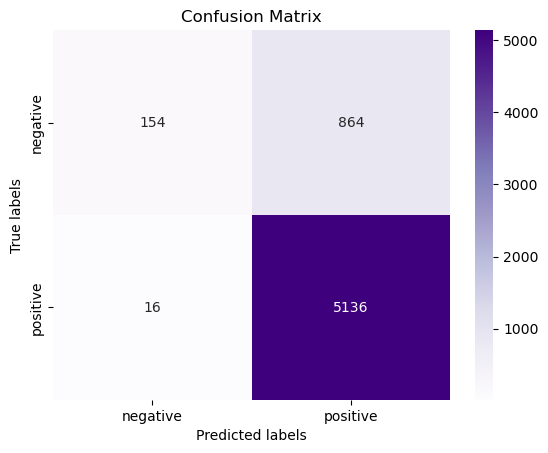

In [40]:
# confusion matrix
nbm_predictions=nbm.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,nbm_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Purples');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [41]:
# testing the model with sample 'Negative' review
demo_review = np.array(['Defective. Bad. Stopped working after one day use'])
demo_review_X_test = tvec.transform(demo_review)
print(nbm.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [42]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Good product. highly recommend buying.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(nbm.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]
